In [ ]:
"""Hyformer + Gumbeldore sampling with Incremental SBS."""

%load_ext autoreload
%autoreload 2

from collections.abc import Callable

import numpy as np
import torch
from transformers import PreTrainedTokenizerBase as Tokenizer

from joint_improvement.utils.chemistry import calculate_logp, calculate_validity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# auxiliary imports

# from hyformer.utils import create_dataloader


def build_hyformer_tokenizer(tokenizer_config_path: str, version: str) -> Tokenizer:
    if version == "v1":
        from hyformer import AutoTokenizer
        from hyformer.configs.tokenizer import TokenizerConfig

        tokenizer_config = TokenizerConfig.from_config_file(tokenizer_config_path)
        tokenizer = AutoTokenizer.from_config(tokenizer_config)
        return tokenizer
    if version == "v2":
        raise NotImplementedError("Tokenizer v2 not implemented")
    else:
        raise ValueError(f"Invalid tokenizer version: {version}. Available versions: v1, v2")


def build_hyformer_model(
    model_config_path: str,
    model_ckpt_path: str = None,
    device: torch.device = None,
    sampler: str = None,
    num_tasks: int = 1,
    downstream_task: str = "regression",
):
    """Legacy wrapper for Hyformer model with Gumbeldore sampling."""
    from hyformer.configs import ModelConfig

    if sampler == "gumbeldore_v1":
        from hyformer.models.hyformer import HyformerForDownstreamPrediction

        from src.joint_improvement.generators.gumbeldore import GumbeldoreMixinV1

        class HyformerSampler(GumbeldoreMixinV1, HyformerForDownstreamPrediction):
            """MRO priorizites `generate` method from `GumbeldoreMixinV1`."""

            pass
    elif sampler == "gumbeldore_v2":
        from src.joint_improvement.generators.gumbeldore import GumbeldoreMixinV2

        class HyformerSampler(GumbeldoreMixinV2, HyformerForDownstreamPrediction):
            """MRO priorizites `generate` method from `GumbeldoreMixinV2`."""

            pass
    else:
        raise ValueError(f"Invalid sampler: {sampler}. Available samplers: gumbeldore_v1, gumbeldore_v2")

    model_config = ModelConfig.from_config_file(model_config_path)
    model = HyformerSampler.from_config(model_config, num_tasks=num_tasks, downstream_task=downstream_task)
    if model_ckpt_path is not None:
        model.load_pretrained(model_ckpt_path)
    if device is not None:
        model.to(device)
    return model

In [ ]:
tokenizer = build_hyformer_tokenizer("configs/legacy/smiles/tokenizer_config.json", version="v1")

In [ ]:
model = build_hyformer_model(
    model_config_path="configs/legacy/smiles/model_config.json",
    model_ckpt_path="configs/legacy/smiles/ckpt.pt",
    sampler="gumbeldore_v1",
)

Model state_dict loaded with strict=True.


In [ ]:
prefix_input_ids = torch.tensor(tokenizer.generation_prefix, dtype=torch.long)

In [ ]:
from functools import partial


def oracle_fn(input_idx: torch.Tensor, tokenizer: Tokenizer) -> list[float]:
    smiles = tokenizer.decode(input_idx.unsqueeze(0))[0]
    is_valid = calculate_validity(smiles)
    if is_valid:
        return calculate_logp(smiles)
    else:
        return -100.0


oracle = partial(oracle_fn, tokenizer=tokenizer)

In [ ]:
def advantage_fn(prediction: float) -> float:
    return (prediction - 5.0) ** 2

In [ ]:
beam_width = 64
num_rounds = 10
eos_token_id = 591
max_sequence_length = 128
advantage_constant = 2.0
min_nucleus_top_p = 1.0

samples = model.generate(
    prefix_input_ids=prefix_input_ids,
    advantage_fn=lambda x: x,
    oracle_fn=None,
    max_sequence_length=max_sequence_length,
    eos_token_id=eos_token_id,
    advantage_constant=advantage_constant,
    beam_width=beam_width,
    num_rounds=num_rounds,
    min_nucleus_top_p=min_nucleus_top_p,
)

In [ ]:
smiles = tokenizer.decode(samples)
print(f"Validity: {len([smile for smile in smiles if calculate_validity(smile)]) / len(smiles):.3f}")

smiles_valid = [smile for smile in smiles if calculate_validity(smile)]
target_values = [calculate_logp(smile) for smile in smiles_valid]

Validity: 0.942


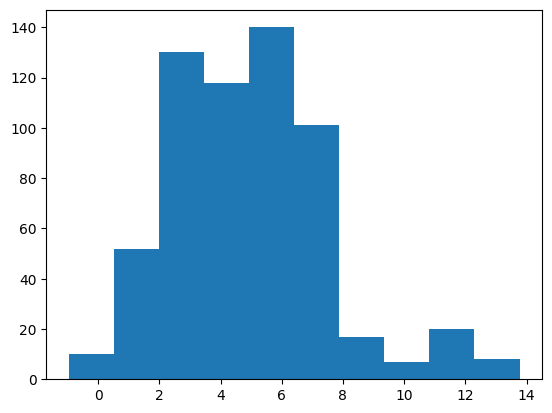

Mean: 4.978
Median: 4.806
Standard Deviation: 2.573
Minimum: -0.965
Maximum: 13.773


In [ ]:
# plot histogram of target values

import matplotlib.pyplot as plt

plt.hist(target_values, bins=10)
plt.show()

# print descriptive statistics
print(f"Mean: {np.mean(target_values):.3f}")
print(f"Median: {np.median(target_values):.3f}")
print(f"Standard Deviation: {np.std(target_values):.3f}")
print(f"Minimum: {np.min(target_values):.3f}")
print(f"Maximum: {np.max(target_values):.3f}")

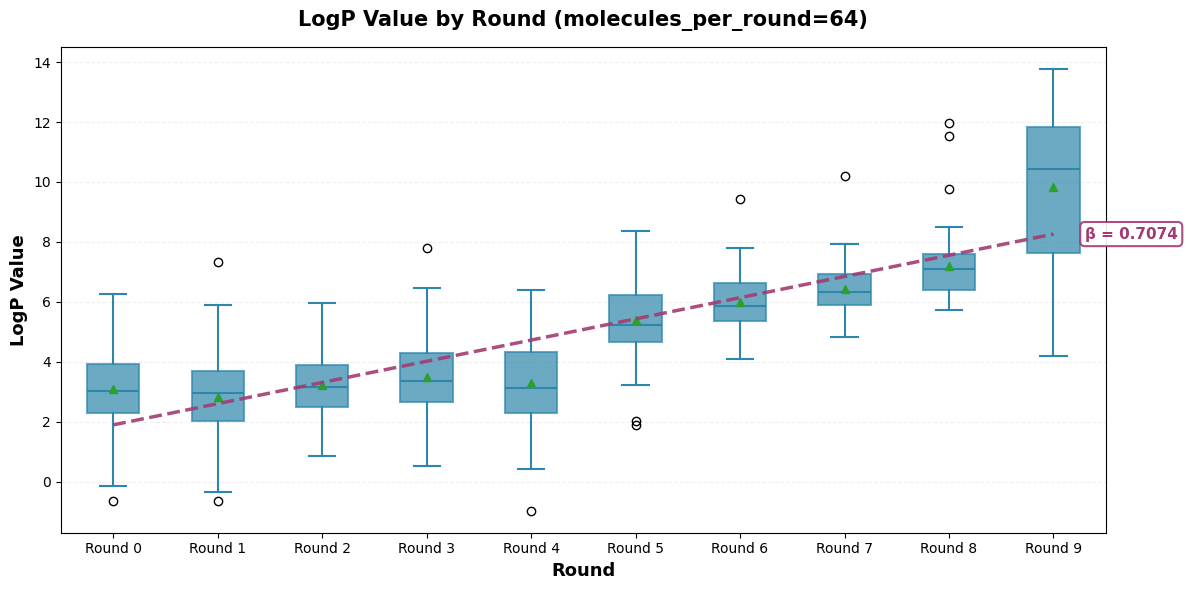


Overall Validity: 0.942
Total SMILES: 640
Valid SMILES: 603

Statistics by Round:
------------------------------------------------------------
Round 0:
  Validity: 0.969 (62/64)
  Count: 62
  Mean: 3.103
  Median: 3.014
  Std: 1.493
  Min: -0.643
  Max: 6.249

Round 1:
  Validity: 0.984 (63/64)
  Count: 63
  Mean: 2.823
  Median: 2.951
  Std: 1.487
  Min: -0.639
  Max: 7.340

Round 2:
  Validity: 0.984 (63/64)
  Count: 63
  Mean: 3.232
  Median: 3.162
  Std: 1.128
  Min: 0.864
  Max: 5.957

Round 3:
  Validity: 0.984 (63/64)
  Count: 63
  Mean: 3.490
  Median: 3.372
  Std: 1.422
  Min: 0.512
  Max: 7.805

Round 4:
  Validity: 0.969 (62/64)
  Count: 62
  Mean: 3.308
  Median: 3.141
  Std: 1.448
  Min: -0.965
  Max: 6.381

Round 5:
  Validity: 0.938 (60/64)
  Count: 60
  Mean: 5.386
  Median: 5.239
  Std: 1.344
  Min: 1.896
  Max: 8.374

Round 6:
  Validity: 0.969 (62/64)
  Count: 62
  Mean: 6.004
  Median: 5.861
  Std: 1.014
  Min: 4.093
  Max: 9.448

Round 7:
  Validity: 0.938 (60/64)

In [ ]:


def _group_smiles_by_round(smiles: list[str], num_molecules_per_round: int) -> tuple[list[int], dict[int, list[str]]]:
    """Group SMILES strings by round and return round indices."""
    num_rounds = len(smiles) // num_molecules_per_round
    round_indices = [round_idx for round_idx in range(num_rounds) for _ in range(num_molecules_per_round)][
        : len(smiles)
    ]

    smiles_by_round = {round_idx: [] for round_idx in range(num_rounds)}
    for smile, round_idx in zip(smiles, round_indices, strict=False):
        smiles_by_round[round_idx].append(smile)

    return round_indices, smiles_by_round


def _calculate_validity_fractions(smiles_by_round: dict[int, list[str]]) -> dict[int, float]:
    """Calculate validity fraction for each round."""
    validity_fractions = {}
    for round_idx, round_smiles in smiles_by_round.items():
        if len(round_smiles) > 0:
            valid_count = sum(1 for s in round_smiles if calculate_validity(s))
            total_count = len(round_smiles)
            validity_fractions[round_idx] = valid_count / total_count
        else:
            validity_fractions[round_idx] = np.nan
    return validity_fractions


def _extract_target_values(
    smiles: list[str], round_indices: list[int], target_fn: Callable[[str], float]
) -> tuple[np.ndarray, np.ndarray]:
    """Extract target values for valid SMILES and their round indices."""
    target_values = []
    valid_round_indices = []

    for smile, round_idx in zip(smiles, round_indices, strict=False):
        if calculate_validity(smile):
            target_values.append(target_fn(smile))
            valid_round_indices.append(round_idx)

    return np.array(target_values), np.array(valid_round_indices)


def _group_targets_by_round(
    target_values: np.ndarray, valid_round_indices: np.ndarray, num_rounds: int
) -> tuple[dict[int, np.ndarray], dict[int, float]]:
    """Group target values by round and calculate means."""
    round_data = {}
    round_means = {}

    for round_idx in range(num_rounds):
        round_mask = valid_round_indices == round_idx
        if np.any(round_mask):
            round_data[round_idx] = target_values[round_mask]
            round_means[round_idx] = np.mean(round_data[round_idx])
        else:
            round_means[round_idx] = np.nan

    return round_data, round_means


def _fit_trend_line(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, float]:
    """Fit a linear trend line and return the line and slope coefficient."""
    if len(y) < 2:
        return np.array([]), 0.0
    coeffs = np.polyfit(x, y, 1)
    trend_line = np.poly1d(coeffs)(x)
    return trend_line, coeffs[0]


def _add_trend_annotation(ax, x_pos: float, y_pos: float, slope: float, color: str):
    """Add a trend coefficient annotation to the plot."""
    text = f"β = {slope:.4f}"
    ax.text(
        x_pos,
        y_pos,
        text,
        fontsize=11,
        color=color,
        fontweight="bold",
        verticalalignment="center",
        bbox={
            "boxstyle": "round,pad=0.3",
            "facecolor": "white",
            "edgecolor": color,
            "linewidth": 1.5,
            "alpha": 0.9,
        },
    )


def _calculate_zoomed_ylim(values: np.ndarray, padding: float = 0.05) -> tuple[float, float]:
    """Calculate zoomed y-axis limits with padding."""
    if len(values) == 0:
        return 0.0, 1.0

    v_min, v_max = np.nanmin(values), np.nanmax(values)
    v_range = v_max - v_min

    if v_range < 0.1:
        y_min = max(0, v_min - padding)
        y_max = min(1, v_max + padding)
    else:
        y_min = max(0, v_min - padding * v_range)
        y_max = min(1, v_max + padding * v_range)

    return y_min, y_max


def plot_target_values_by_round(
    smiles: list[str],
    num_molecules_per_round: int,
    target_fn: Callable[[str], float],
    target_label: str = "Target Value",
    title: str | None = None,
) -> None:
    """
    Plot target values grouped by rounds with box plots, trend line, and validity fraction.

    Parameters
    ----------
    smiles : List[str]
        List of SMILES strings, ordered by rounds (num_molecules_per_round per round)
    num_molecules_per_round : int
        Number of molecules generated per round (beam_width)
    target_fn : Callable[[str], float]
        Function that takes a SMILES string and returns a target value (e.g., calculate_logp)
    target_label : str, optional
        Label for the target value axis (default: "Target Value")
    title : str, optional
        Plot title (default: auto-generated)
    """
    import matplotlib.pyplot as plt

    # Data processing
    round_indices, smiles_by_round = _group_smiles_by_round(smiles, num_molecules_per_round)
    validity_fractions_dict = _calculate_validity_fractions(smiles_by_round)
    target_values, valid_round_indices = _extract_target_values(smiles, round_indices, target_fn)

    num_rounds = len(smiles_by_round)
    round_data, round_means = _group_targets_by_round(target_values, valid_round_indices, num_rounds)

    # Publication-ready color palette (colorblind-friendly)
    colors = {"box": "#2E86AB", "target_trend": "#A23B72"}

    # Prepare plotting data
    round_numbers = sorted(round_data.keys())
    round_values = [round_data[r] for r in round_numbers]
    round_labels = [f"Round {r}" for r in round_numbers]
    x_positions = np.array(range(len(round_numbers)))
    mean_values = np.array([round_means[r] for r in round_numbers])

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Plot box plots
    box_plot = ax.boxplot(
        round_values, positions=x_positions, tick_labels=round_labels, patch_artist=True, showmeans=True
    )
    for patch in box_plot["boxes"]:
        patch.set_facecolor(colors["box"])
        patch.set_alpha(0.7)
        patch.set_edgecolor(colors["box"])
        patch.set_linewidth(1.5)
    for element in ["whiskers", "fliers", "means", "medians", "caps"]:
        if element in box_plot:
            plt.setp(box_plot[element], color=colors["box"], linewidth=1.5)

    # Plot target trend line
    target_trend_line, target_slope = _fit_trend_line(x_positions, mean_values)
    if len(target_trend_line) > 0:
        ax.plot(x_positions, target_trend_line, "--", color=colors["target_trend"], linewidth=2.5, alpha=0.9, zorder=10)
        _add_trend_annotation(ax, x_positions[-1] + 0.3, target_trend_line[-1], target_slope, colors["target_trend"])

    # Configure main axis
    ax.set_xlabel("Round", fontsize=13, fontweight="bold", color="black")
    ax.set_ylabel(target_label, fontsize=13, fontweight="bold", color="black")
    ax.tick_params(axis="both", colors="black")
    if title is None:
        title = f"{target_label} by Round (molecules_per_round={num_molecules_per_round})"
    ax.set_title(title, fontsize=15, fontweight="bold", pad=15, color="black")
    ax.grid(True, alpha=0.2, axis="y", linestyle="--", linewidth=0.8)

    plt.tight_layout()
    plt.show()

    # Print overall validity for comparison
    overall_validity = len([s for s in smiles if calculate_validity(s)]) / len(smiles) if len(smiles) > 0 else 0.0
    print(f"\nOverall Validity: {overall_validity:.3f}")
    print(f"Total SMILES: {len(smiles)}")
    print(f"Valid SMILES: {len([s for s in smiles if calculate_validity(s)])}")

    # Print statistics - include all rounds with smiles
    all_rounds_with_smiles = sorted(
        [r for r in validity_fractions_dict.keys() if not np.isnan(validity_fractions_dict[r])]
    )
    print("\nStatistics by Round:")
    print("-" * 60)
    for round_idx in all_rounds_with_smiles:
        validity_frac = validity_fractions_dict[round_idx]
        validity_str = f"{validity_frac:.3f}" if not np.isnan(validity_frac) else "N/A"

        # Get round info for debugging
        round_smiles = smiles_by_round.get(round_idx, [])
        round_valid_count = sum(1 for s in round_smiles if calculate_validity(s))
        round_total_count = len(round_smiles)

        print(f"Round {round_idx}:")
        print(f"  Validity: {validity_str} ({round_valid_count}/{round_total_count})")

        if round_idx in round_data:
            values = round_data[round_idx]
            print(f"  Count: {len(values)}")
            print(f"  Mean: {np.mean(values):.3f}")
            print(f"  Median: {np.median(values):.3f}")
            print(f"  Std: {np.std(values):.3f}")
            print(f"  Min: {np.min(values):.3f}")
            print(f"  Max: {np.max(values):.3f}")
        else:
            print("  Count: 0 (no valid target values)")
        print()


# Use the function
plot_target_values_by_round(
    smiles=smiles, num_molecules_per_round=beam_width, target_fn=calculate_logp, target_label="LogP Value"
)

In [ ]:
smiles

['COc1ccc(-c2ccc(F)c(C)c2)cc1-n1c(=O)ccc2cc(S(=O)(=O)Nc3ccon3)ccc21',
 'C=C1CCCC2C1(C)CC(O)C1C(C)(C)C(OC(=O)C(C)C)CCC12C',
 'COc1cc([N+](=O)[O-])cc(-c2c[nH]c(C(O)c3c(C)c(Cl)cc(F)c3O)n2)c1O',
 'CC(=O)NCC1CN(c2ccc(N3Cc4ccncc4C3)c(F)c2)C(=O)O1',
 'CN(C)C(=O)NCC1c2ccccc2C(COC(=O)c2ccccc2)C1OC1CC2C(=O)NC(=O)C2C1',
 'COc1cc(O)c(C(=O)NCc2ccc(C)c(F)c2)cc1Br',
 'O=C1c2[nH]ncc2C(C2CCCCC2)N1c1ccc(F)cc1',
 'CN(N1C2=NC(Nc3nc4ccccc4o3)=NC1=O)c1ccc(C#N)cc1',
 'COc1ccc(C=C2C(=O)N(c3c(Cl)cccc3Cl)N=C2C(F)(F)F)cc1OS(=O)(=O)c1ccc(C)cc1',
 'CC1CCC2(OC1)OC1CC3C4CCC5CC(OC6OC(CO)C(O)C(OS(=O)(=O)O)C6O)CCC5(C)C4CCC3(C)C1C2C',
 'COc1cc2c(cc1OCCCCN1CCCCC1)N=C(N=C(O)c1ccccc1)N1CCN=C21',
 'Cc1cc(C#N)c(C)n1CCC(=O)OCC(=O)NCCc1ccccc1',
 'CN(C)CCn1nnc2ccc(C(F)(F)F)cc2c1=O',
 'Cc1c(Cl)c([N+](=O)[O-])nn1CC(=O)Nc1ccccc1C(C)C',
 'CC(C)(C)OC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1c[nH]cn1)C(=O)O',
 'Cc1csc(N2CCN(C(=O)CN(C)S(=O)(=O)c3ccc4c(c3)OCCO4)CC2)n1',
 'CC(=O)NCCN1CCC(n2nc(C)cc2C)CC1',
 'O=[N+]([O-])c1cc(-c2csc(NN=C3CCCCCC3)n2)ccc